# ACCESS-OM3 SST and SST difference from WOA23

Related issue: https://github.com/ACCESS-Community-Hub/access-om3-25km-paper-1/issues/9

In [ ]:
#parameters

### USER EDIT start
# esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
esm_file='/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

# needed for mkmd START 
notebook_name='not_using_mkfigs.sh'
notebooks_dir = os.path.join(f"/g/data/tm70/{os.environ['USER']}/access-om3-paper-1", "notebooks")
os.chdir(notebooks_dir)
print("Changed working directory to:", os.getcwd())
from mkfigs_configdoc import mkmd,get_notebook_name
notebook_name=get_notebook_name(notebook_name)
## example usage (note if the first argument to mkmd remains the same, you can insert multiple figures from the same notebook): 
#plt.savefig(notebooks_dir+'/mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')
#mkmd("Template notebook","`"+notebook_name+"`: Example figure of ACCESS-OM3 sea surface height (m).",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')
#mkmd("Template notebook","`"+notebook_name+"`: Example figure of another type.",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')
# needed for mkmd STOP

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json
Plot folder path:  /g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkfigs_output/2/


In [2]:
import xarray as xr
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
from pint import application_registry as ureg
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client
import cftime
import os
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from textwrap import wrap
xr.set_options(keep_attrs=True);  # cf_xarray works best when xarray keeps attributes by default

In [3]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35103 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:43181' processes=14 threads=14, memory=63.00 GiB>

### Define plot function

In [4]:
blue_marble = plt.imread('/g/data/ik11/grids/BlueMarble.tiff')
blue_marble_extent = (-180, 180, -90, 90)

In [5]:
def plot(dat, title=None, **kwargs):
    if title is None:
        title = dat.attrs['long_name']
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    dat.plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={"label": "\n".join(wrap(f"{dat.attrs['long_name']} [{dat.attrs['units']}]", 45)),
                     "fraction": 0.03, "aspect": 15, "shrink": 0.7},
        **kwargs
    )
    
    # Add blue marble land:
    ax.imshow(
        blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
    )
    
    plt.title(title);

### Load and plot data from ACCESS-OM3

In [6]:
exptname=os.path.basename(os.path.dirname(esm_file))

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [7]:
exptname

'25km-iaf-test-for-AK-expt-7df5ef4c'

In [8]:
geolon = datastore.search(variable="geolon").to_dask().geolon
geolat = datastore.search(variable="geolat").to_dask().geolat

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/source.py:306: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  reco

In [9]:
variable = "tos"
model_all = datastore.search(variable=variable, frequency="1day").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    ),
    xarray_combine_by_coords_kwargs=dict(
        compat="override",
        data_vars="minimal",
        coords="minimal"
    )
)[variable].cf.assign_coords({ "longitude": geolon, "latitude": geolat })

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [10]:
##### ONLY NEEDED FOR 25km-iaf-test-for-AK-expt-7df5ef4c !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# omit latitudes with grid bug https://github.com/ACCESS-NRI/ocean_model_grid_generator/issues/7
model_all = model_all.isel(yh=slice(10, None))
geolon = geolon.isel(yh=slice(10, None))
geolat = geolat.isel(yh=slice(10, None))

In [11]:
# for IAF
model_all = model_all.convert_calendar("proleptic_gregorian", use_cftime=True)

In [12]:
model_all.time.values[0] # initial date in data

cftime.DatetimeProlepticGregorian(1958, 1, 1, 12, 0, 0, 0, has_year_zero=True)

In [13]:
model_all.time.values[-1] # final date in data

cftime.DatetimeProlepticGregorian(2023, 12, 31, 12, 0, 0, 0, has_year_zero=True)

In [14]:
# set time range

# timerange = slice(cftime.DatetimeNoLeap(1942, 1, 1, 0, 0, 0, 0),
#                   cftime.DatetimeNoLeap(1952, 1, 1, 0, 0, 0, 0))
# timerange = slice(None, None)
# datestop = model_all.time.values[-1] # final date in data
datestop = cftime.DatetimeProlepticGregorian(2018, 12, 14, 12, 0, 0, 0, has_year_zero=True)  # to match OM2 IAF run
datelist = list(cftime.to_tuple(datestop))
datelist[0] -= 10  # last 10 years
datestart = cftime.datetime(*datelist, calendar=datestop.calendar)
timerange = slice(datestart, datestop)

In [15]:
datestart

cftime.datetime(2008, 12, 14, 12, 0, 0, 0, calendar='proleptic_gregorian', has_year_zero=True)

In [16]:
datestop

cftime.DatetimeProlepticGregorian(2018, 12, 14, 12, 0, 0, 0, has_year_zero=True)

In [17]:
model_all = model_all.sel(time=timerange)

In [18]:
%%time
model = model_all.mean('time').load()

CPU times: user 7 s, sys: 1.51 s, total: 8.51 s
Wall time: 49.2 s


In [19]:
model = model.pint.quantify().pint.to('C').pint.dequantify()

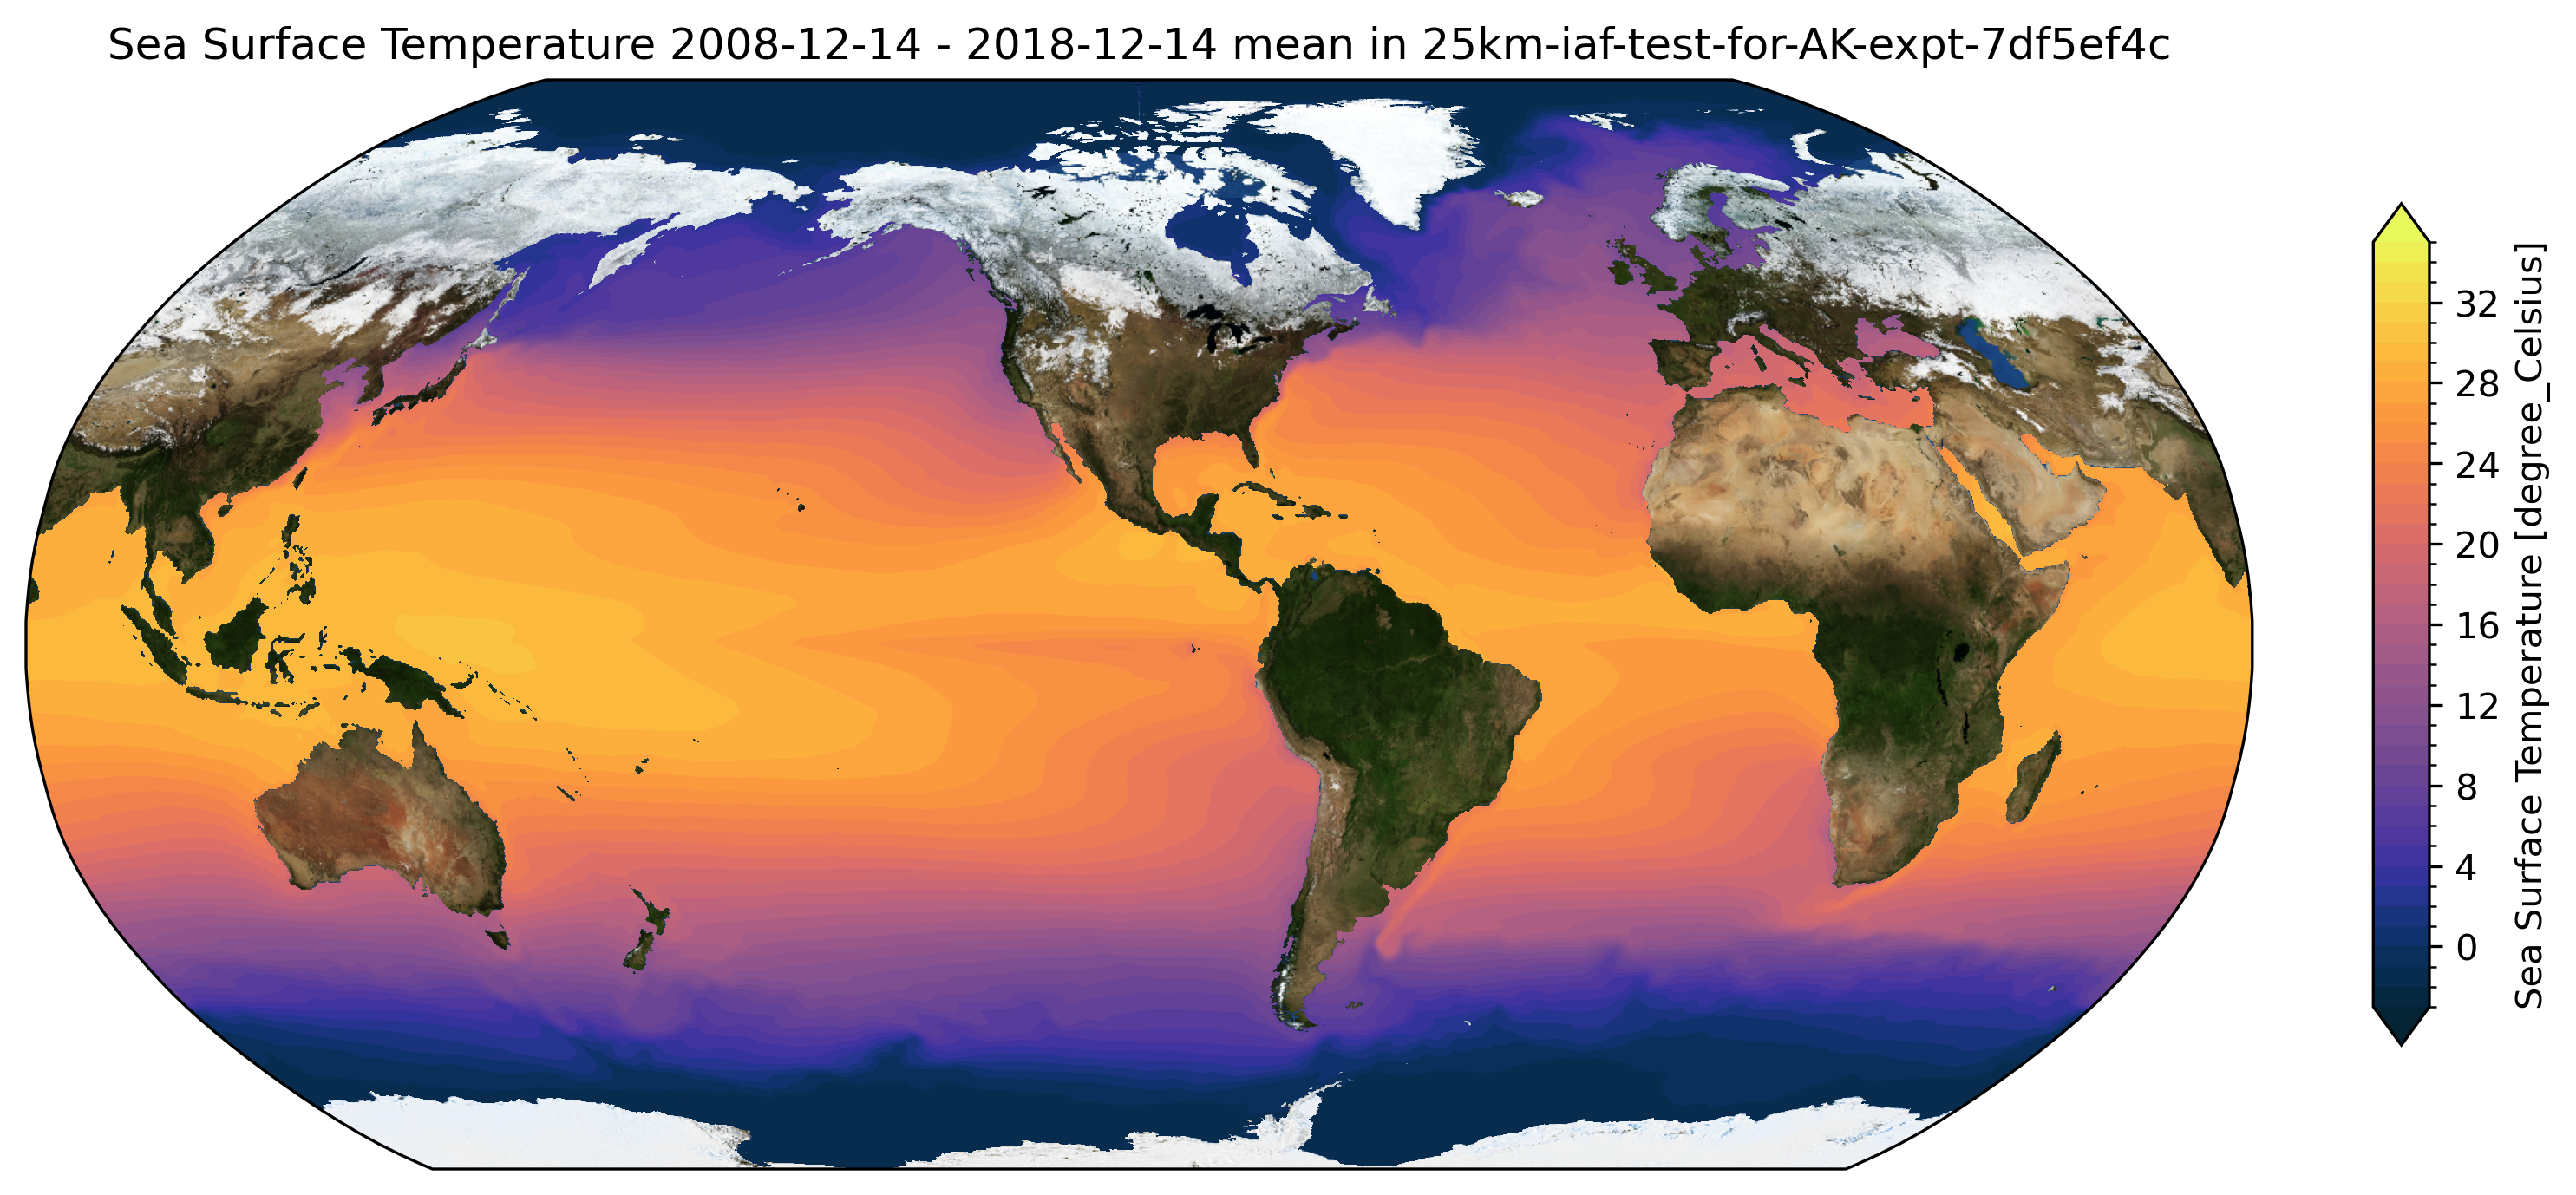

In [20]:
plot(model,
    levels=39,
    vmin=-3,
    vmax=35,
    extend="both",
    cmap=cm.cm.thermal,
    title=f"{model.attrs['long_name']} {model_all.time.values[0].strftime('%Y-%m-%d')} - {model_all.time.values[-1].strftime('%Y-%m-%d')} mean in {exptname}"
    )

### Load data from WOA23 (annual mean; Jan is ACCESS-OM3 initial condition)

In [21]:
obs = xr.open_mfdataset('/g/data/ik11/inputs/access-om3/woa23/025/2025.08.26/woa23_ts_*', 
                            chunks={'time': -1}
                       )['temp'].isel(depth=0).mean('time').rename({'lat': 'yh', 'lon': 'xh'}).load()

In [22]:
##### ONLY NEEDED FOR 25km-iaf-test-for-AK-expt-7df5ef4c !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# omit latitudes with grid bug https://github.com/ACCESS-NRI/ocean_model_grid_generator/issues/7
obs = obs.isel(yh=slice(10, None))

In [23]:
obs = obs.cf.assign_coords({ "longitude": geolon, "latitude": geolat })

### Plot ACCESS-OM3 minus WOA23
First plot full range, then a sequence at specified ranges.

**BUG? is WOA initial condition data conservative temperature, but model data potential temperature? - CHECK!**

In [24]:
bias = (model - obs).load().cf.assign_coords({ "longitude": geolon, "latitude": geolat })

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.14 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.14 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


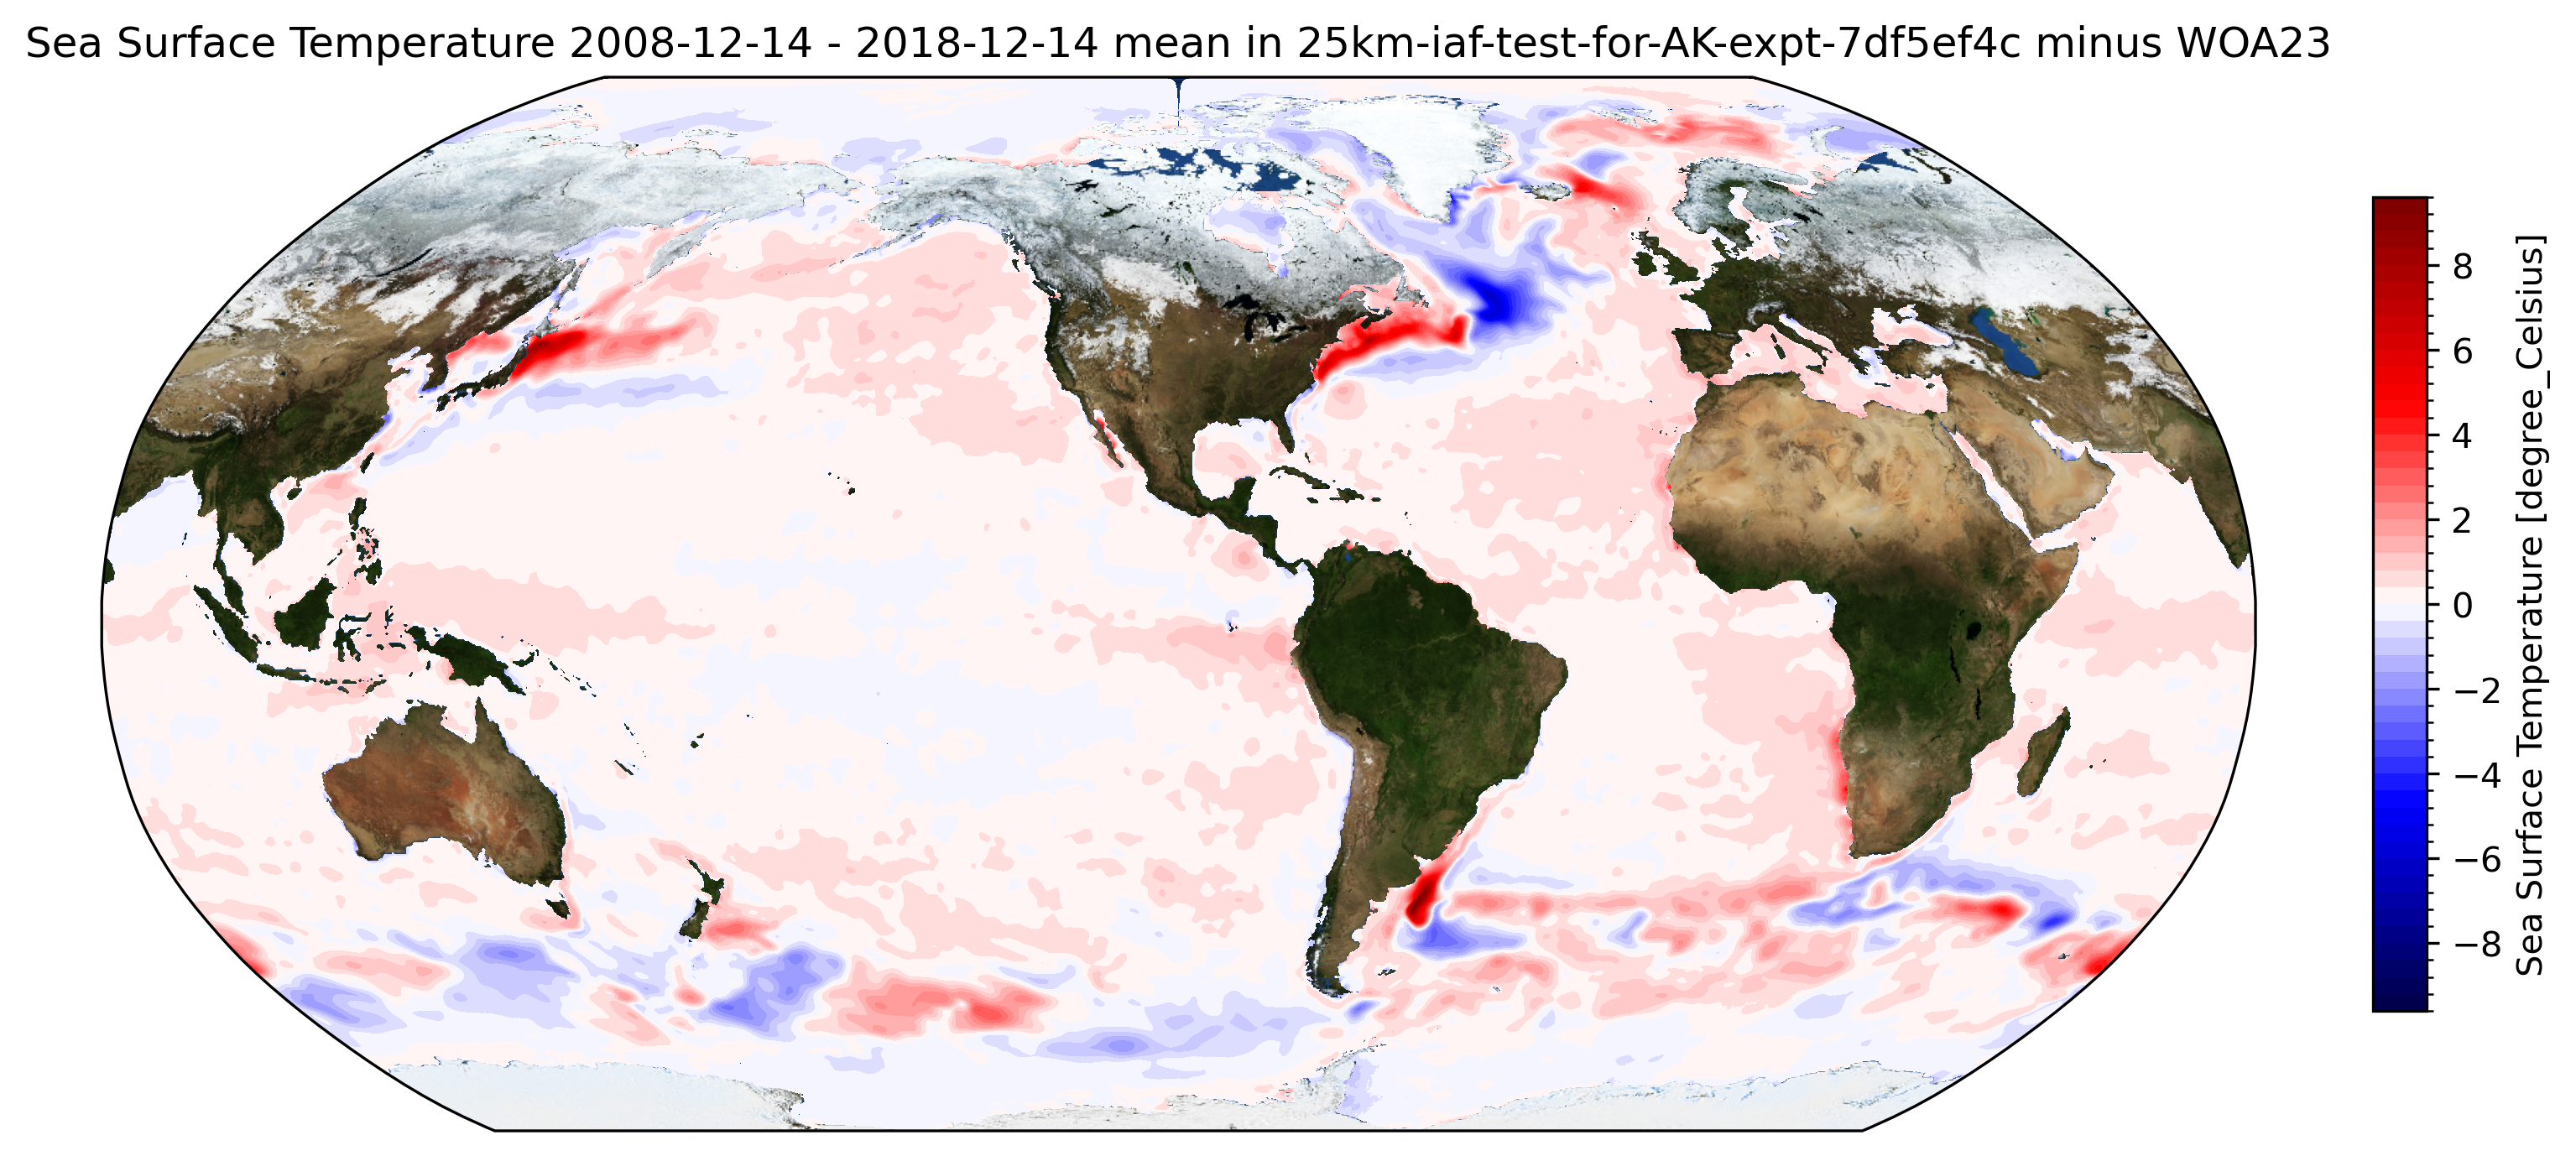

In [25]:
plot(bias,
    levels=61,
    cmap='seismic',
    title=f"{model.attrs['long_name']} {model_all.time.values[0].strftime('%Y-%m-%d')} - {model_all.time.values[-1].strftime('%Y-%m-%d')} mean in {exptname} minus WOA23"
    )

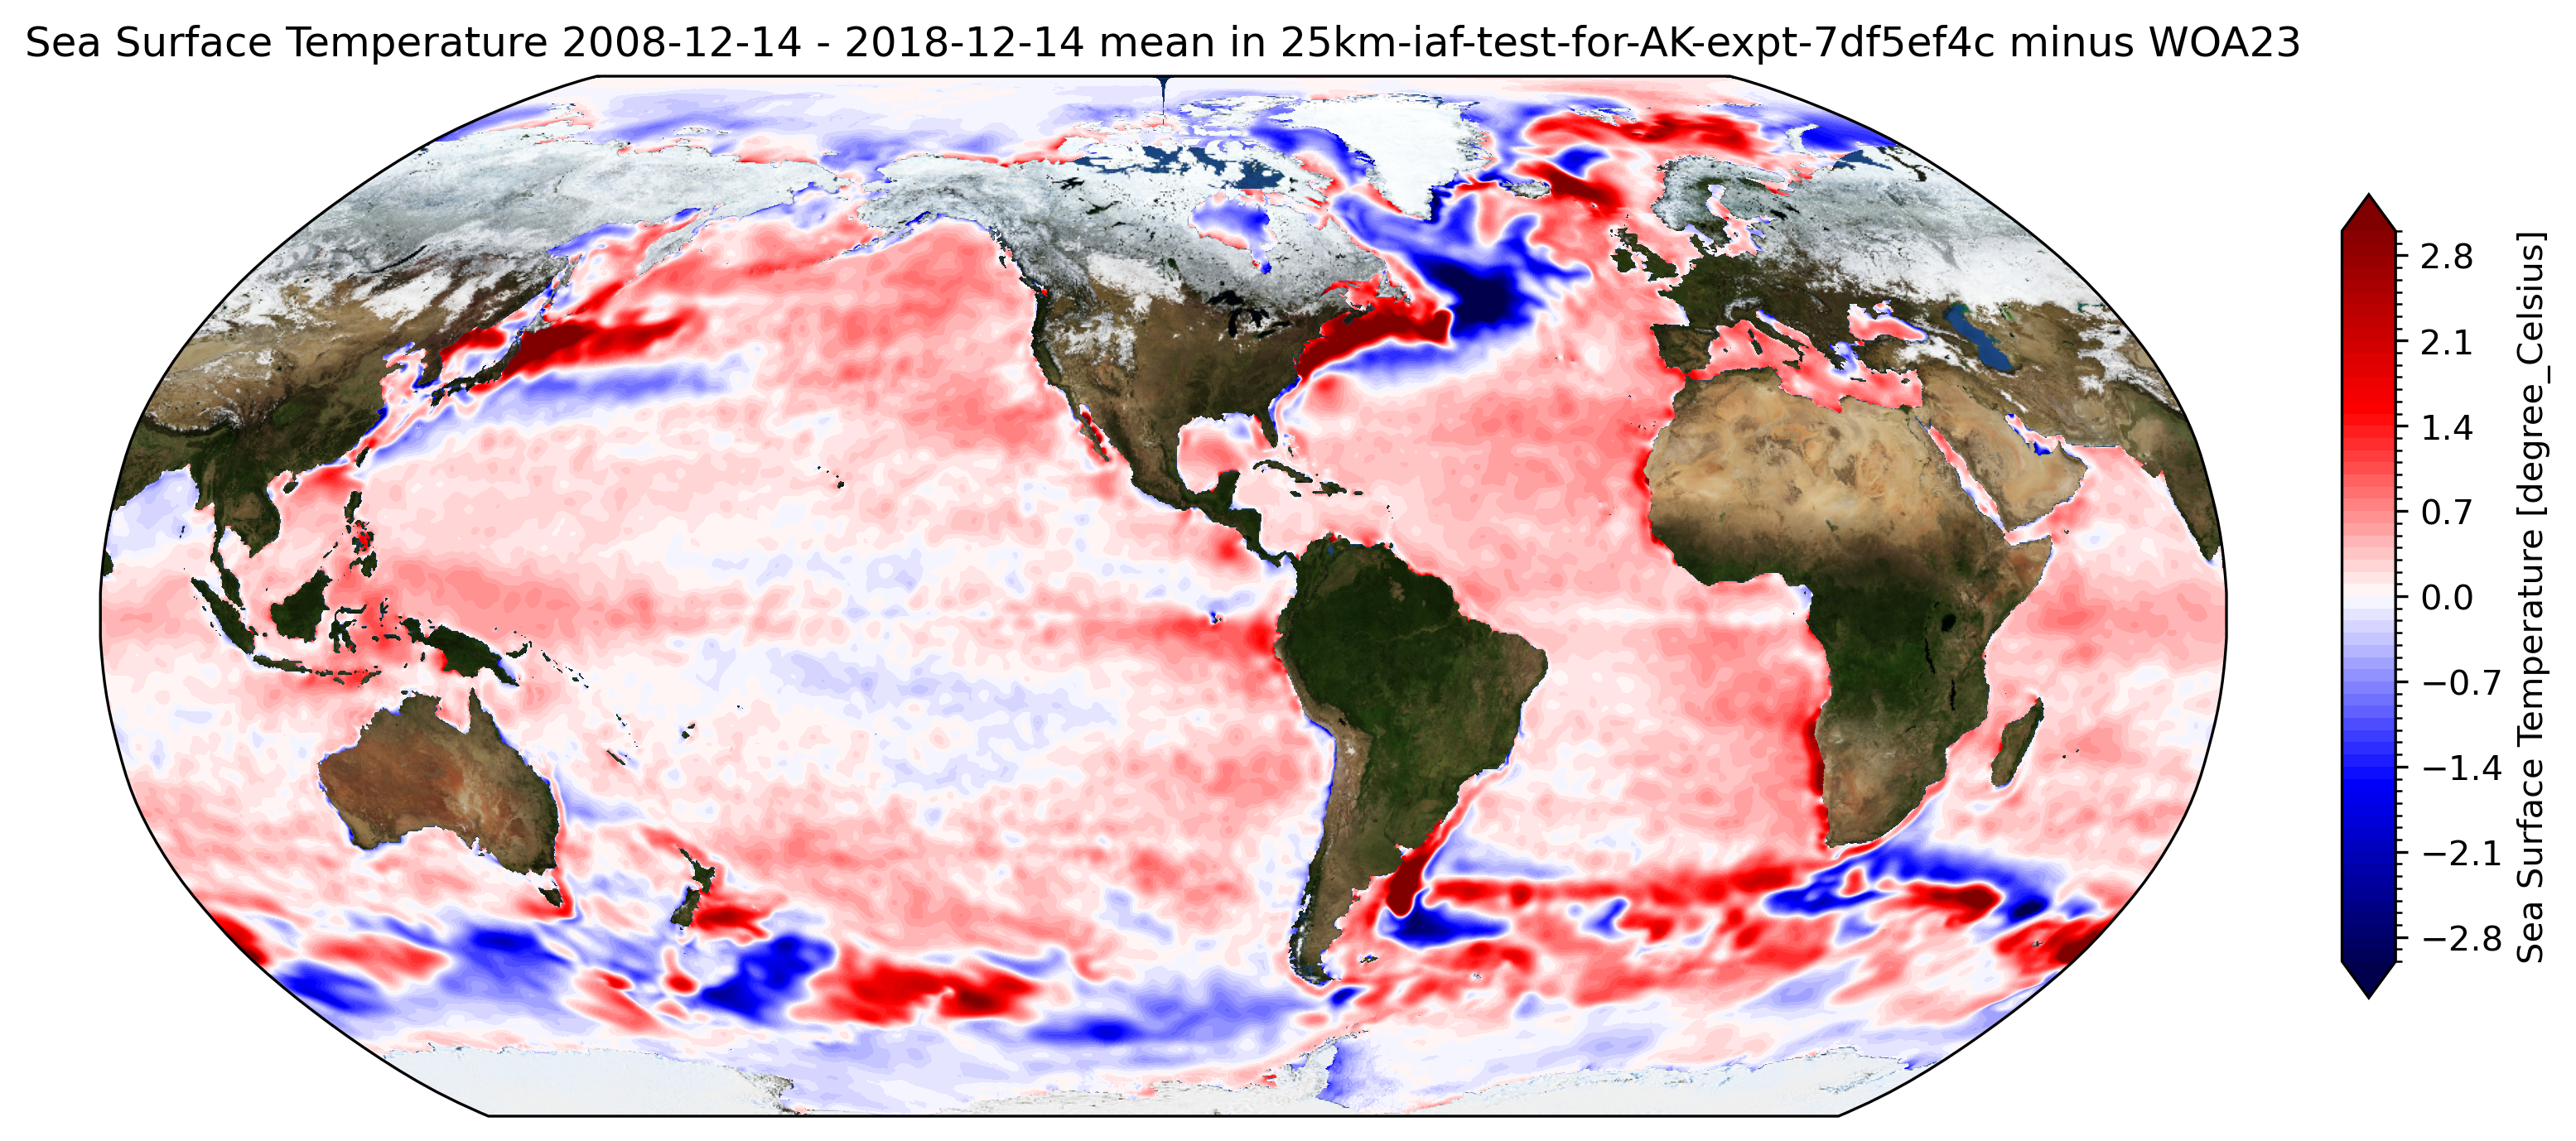

In [26]:
plot(bias,
    levels=61,
    vmin=-3,
    vmax=3,
    extend="both",
    cmap='seismic',
    title=f"{model.attrs['long_name']} {model_all.time.values[0].strftime('%Y-%m-%d')} - {model_all.time.values[-1].strftime('%Y-%m-%d')} mean in {exptname} minus WOA23"
    )

In [27]:
client.close()